# Vertigo Games – Data Analyst Case  
### **Task 1: A/B Test Modeling & Simulation**  
Atamert Bilgin  
**Tools:** Python, NumPy, Pandas, Matplotlib  

In [452]:
import sys
sys.path.append("../src")

from abtest.config import *
from abtest.retention import ret_A, ret_B
from abtest.dau import dau_on_calendar_day, dau_with_two_sources
from abtest.monetization import daily_revenue, daily_revenue_with_sale
from abtest.scenarios import simulate_baseline, simulate_sale, simulate_new_source


### Retention Function
We first interpolate retention up to D14, then apply exponential decay afterward.

### Exponential Decay for Retention (After D14)

Mobile game retention usually declines quickly early on, then slows down.  
This pattern is well-modeled by **exponential decay**:



- So I've used **interpolation** for all days up to **D14**.  
- After **D14**, continued the curve by applying the **same daily decay rate** found in the last known segment (D7→D14):


### a) Which variant will have the most daily active users after 15 days?

### 🔍 Interpretation (Day 15 Result)
- Variant A DAU ≈ XX  
- Variant B DAU ≈ YY  

In [453]:
# DAU on day 15 for each variant
dau_A_day15 = df_dau.loc[df_dau["day"] == 15, "A_dau"].iloc[0]
dau_B_day15 = df_dau.loc[df_dau["day"] == 15, "B_dau"].iloc[0]

dau_A_day15, dau_B_day15, df_dau.tail()

(np.float64(76634.11132201928),
 np.float64(79117.75882549695),
     day         A_dau         B_dau         rev_A         rev_B  \
 11   11  71057.142857  71242.857143  12437.842286  12451.826571   
 12   12  72885.714286  73614.285714  12757.915429  12866.304857   
 13   13  74400.000000  75700.000000  13022.976000  13230.846000   
 14   14  75600.000000  77500.000000  13233.024000  13545.450000   
 15   15  76634.111322  79117.758825  13414.034846  13828.201888   
 
         cum_rev_A      cum_rev_B  
 11  109104.932571  106246.265143  
 12  121862.848000  119112.570000  
 13  134885.824000  132343.416000  
 14  148118.848000  145888.866000  
 15  161532.882846  159717.067888  )

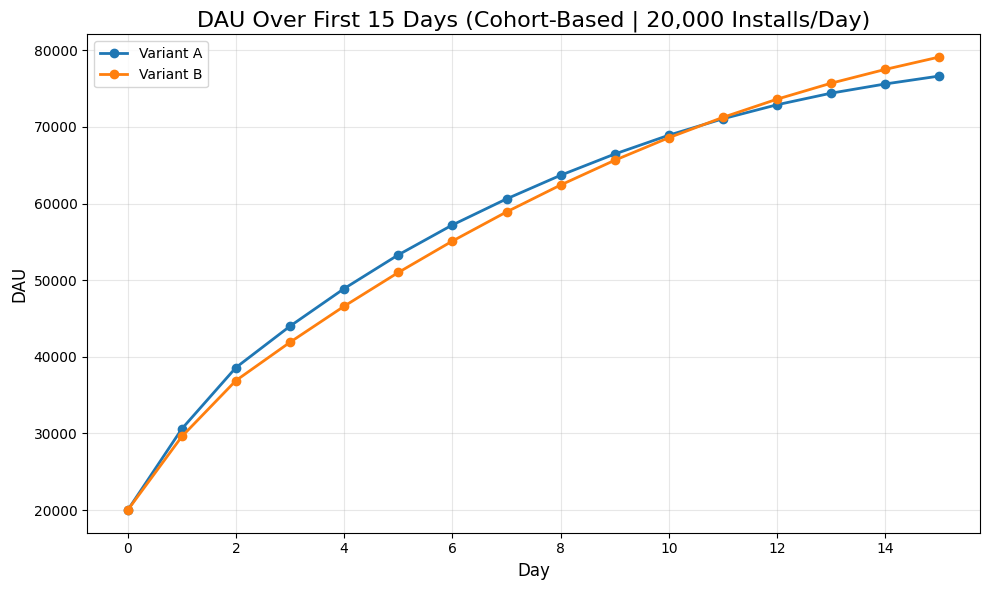

In [454]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(df_dau["day"], df_dau["A_dau"], marker="o", label="Variant A", linewidth=2)
plt.plot(df_dau["day"], df_dau["B_dau"], marker="o", label="Variant B", linewidth=2)

plt.title("DAU Over First 15 Days (Cohort-Based | 20,000 Installs/Day)", fontsize=16)
plt.xlabel("Day", fontsize=12)
plt.ylabel("DAU", fontsize=12)
plt.grid(alpha=0.25)


plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("../outputs/figures/dau_over_15_days.png", dpi=150, bbox_inches="tight")
plt.show()



**Variant B has higher DAU on Day 15 due to stronger long-term retention (D7→D14).**

In [455]:
print(f"DAU Day 15 - Variant A: {dau_A_day15:,.0f}")
print(f"DAU Day 15 - Variant B: {dau_B_day15:,.0f}")


DAU Day 15 - Variant A: 76,634
DAU Day 15 - Variant B: 79,118


### b) Which variant will earn the most total money by Day 15?

In [456]:

# Recompute daily revenue columns
df_dau["rev_A"] = df_dau["A_dau"].apply(lambda x: daily_revenue(x, "A"))
df_dau["rev_B"] = df_dau["B_dau"].apply(lambda x: daily_revenue(x, "B"))

# Recompute totals
rev_A = df_dau["rev_A"].sum()
rev_B = df_dau["rev_B"].sum()

rev_A, rev_B


(np.float64(161532.88284580625), np.float64(159717.06788752036))

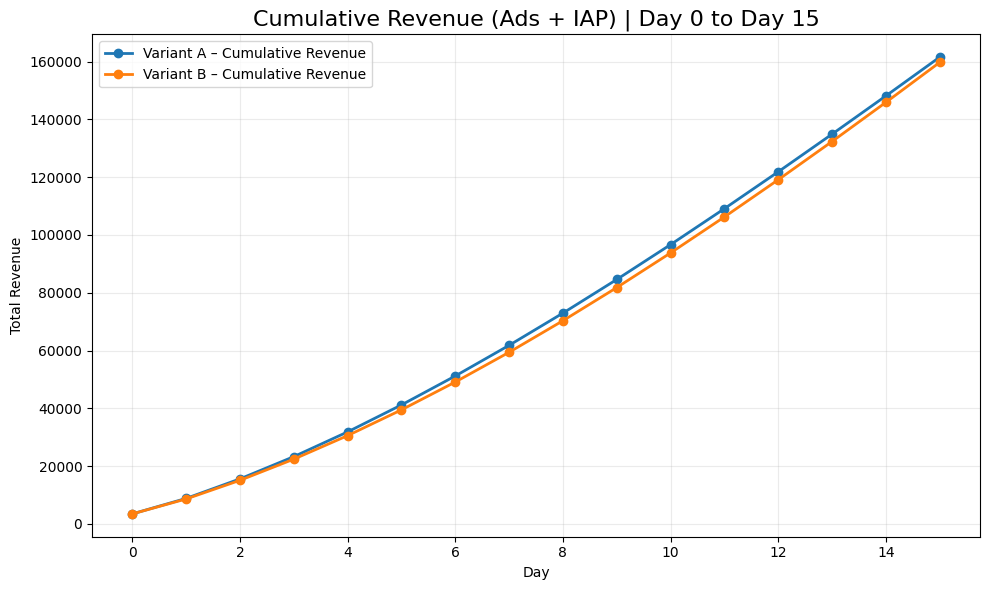

In [457]:
df_dau["cum_rev_A"] = df_dau["rev_A"].cumsum()
df_dau["cum_rev_B"] = df_dau["rev_B"].cumsum()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(df_dau["day"], df_dau["cum_rev_A"], marker="o", linewidth=2, label="Variant A – Cumulative Revenue")
plt.plot(df_dau["day"], df_dau["cum_rev_B"], marker="o", linewidth=2, label="Variant B – Cumulative Revenue")

plt.title("Cumulative Revenue (Ads + IAP) | Day 0 to Day 15", fontsize=16)
plt.xlabel("Day")
plt.ylabel("Total Revenue")
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.savefig("../outputs/figures/cumulative_rev_15days.png", dpi=150, bbox_inches="tight")
plt.show()


**Result:** Variant A earns more total money by Day 15 with better early retention metrics.

### If we look at the total money earned by Day 30 instead, does our choice change?

In [458]:
# Simulate out to Day 30 instead of 15
max_day_30 = 30

dau_data_30 = {
    "day": list(range(max_day_30 + 1)),
    "A_dau": [],
    "B_dau": [],
}

for t in range(max_day_30 + 1):
    dau_data_30["A_dau"].append(dau_on_calendar_day(t, ret_A))
    dau_data_30["B_dau"].append(dau_on_calendar_day(t, ret_B))

df_dau_30 = pd.DataFrame(dau_data_30)

# Revenue calculations for Day 0–30
df_dau_30["rev_A"] = df_dau_30["A_dau"].apply(lambda x: daily_revenue(x, "A"))
df_dau_30["rev_B"] = df_dau_30["B_dau"].apply(lambda x: daily_revenue(x, "B"))

# Totals
rev_A_30 = df_dau_30["rev_A"].sum()
rev_B_30 = df_dau_30["rev_B"].sum()

rev_A_30, rev_B_30


(np.float64(373390.1284317267), np.float64(387001.9742102918))

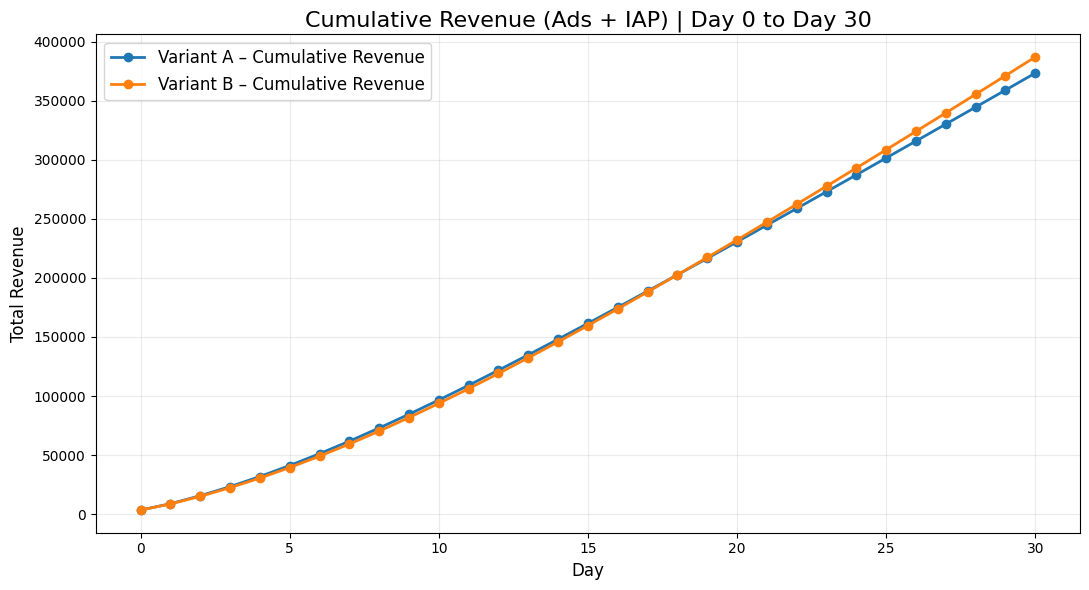

In [459]:
# --- 1. Simulate DAU out to Day 30 ---
max_day_30 = 30

dau_data_30 = {
    "day": list(range(max_day_30 + 1)),
    "A_dau": [],
    "B_dau": [],
}

for t in range(max_day_30 + 1):
    dau_data_30["A_dau"].append(dau_on_calendar_day(t, ret_A))
    dau_data_30["B_dau"].append(dau_on_calendar_day(t, ret_B))

df_dau_30 = pd.DataFrame(dau_data_30)

# --- 2. Compute daily revenue for each variant ---
df_dau_30["rev_A"] = df_dau_30["A_dau"].apply(lambda x: daily_revenue(x, "A"))
df_dau_30["rev_B"] = df_dau_30["B_dau"].apply(lambda x: daily_revenue(x, "B"))

# --- 3. Compute cumulative revenue ---
df_dau_30["cum_rev_A"] = df_dau_30["rev_A"].cumsum()
df_dau_30["cum_rev_B"] = df_dau_30["rev_B"].cumsum()

# --- 4. Plot cumulative revenue curve ---
import matplotlib.pyplot as plt

plt.figure(figsize=(11, 6))

plt.plot(df_dau_30["day"], df_dau_30["cum_rev_A"], 
         marker="o", linewidth=2, label="Variant A – Cumulative Revenue")
plt.plot(df_dau_30["day"], df_dau_30["cum_rev_B"], 
         marker="o", linewidth=2, label="Variant B – Cumulative Revenue")

plt.title("Cumulative Revenue (Ads + IAP) | Day 0 to Day 30", fontsize=16)
plt.xlabel("Day", fontsize=12)
plt.ylabel("Total Revenue", fontsize=12)
plt.grid(alpha=0.25)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("../outputs/figures/cumulative_rev_30days.png", dpi=150, bbox_inches="tight")
plt.show()


**Result:** Variant B earns more total money by Day 30 since it has better long term retention.

### d) What if we run a 10-day sale starting on Day 15?

The sale increases each variant’s purchase rate by +1% from Day 15 to Day 24.
Since Variant B has higher DAU during this period, the IAP boost amplifies
B’s advantage.

In [460]:
# ----- Recompute Day 0–30 Revenue With Sale -----

df_dau_30["rev_A_sale"] = df_dau_30.apply(lambda row: daily_revenue_with_sale(row["day"], row["A_dau"], "A"), axis=1)
df_dau_30["rev_B_sale"] = df_dau_30.apply(lambda row: daily_revenue_with_sale(row["day"], row["B_dau"], "B"), axis=1)

total_A_sale = df_dau_30["rev_A_sale"].sum()
total_B_sale = df_dau_30["rev_B_sale"].sum()

total_A_sale, total_B_sale


(np.float64(413125.4363643669), np.float64(429088.03392836696))

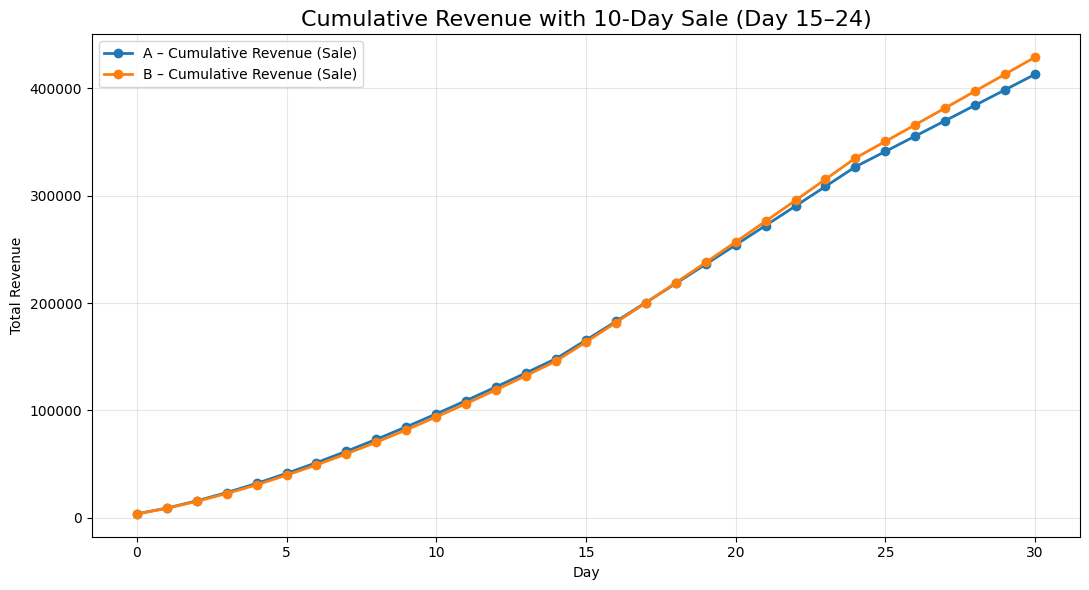

In [461]:
df_dau_30["cum_A_sale"] = df_dau_30["rev_A_sale"].cumsum()
df_dau_30["cum_B_sale"] = df_dau_30["rev_B_sale"].cumsum()

plt.figure(figsize=(11,6))

plt.plot(df_dau_30["day"], df_dau_30["cum_A_sale"], 
         marker="o", label="A – Cumulative Revenue (Sale)", linewidth=2)
plt.plot(df_dau_30["day"], df_dau_30["cum_B_sale"], 
         marker="o", label="B – Cumulative Revenue (Sale)", linewidth=2)

plt.title("Cumulative Revenue with 10-Day Sale (Day 15–24)", fontsize=16)
plt.xlabel("Day")
plt.ylabel("Total Revenue")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("../outputs/figures/cumulative_rev_with_10day_sale.png", dpi=150, bbox_inches="tight")
plt.show()


**Result:** Variant B still earns more total money by Day 30, and the gap
becomes larger compared to the non-sale scenario.

➡️ The sale benefits Variant B more than Variant A.


### e) On Day 20 we add a new user source. From then on, we get 12,000 users from the original source and 8,000 from this new one. The new users' retention is described by these formulas.
### With this mix of old and new users, which variant makes more total money by Day 30?
 ● Variant A (New): $Retention = 0.58 \cdot e^{-0.12(x-1)}$
 
 ● Variant B (New): $Retention = 0.52 \cdot e^{-0.10(x-1)}$


In [462]:

# --- Simulate Day 0–30 DAU + revenue with mixed sources ---

days = list(range(0, 31))
rows = []
for t in days:
    dau_A = dau_with_two_sources(t, "A")
    dau_B = dau_with_two_sources(t, "B")
    rev_A_t = daily_revenue(dau_A, "A")  # uses your existing daily_revenue()
    rev_B_t = daily_revenue(dau_B, "B")
    rows.append((t, dau_A, dau_B, rev_A_t, rev_B_t))

df_mix_30 = pd.DataFrame(rows, columns=["day", "dau_A", "dau_B", "rev_A", "rev_B"])

# Total revenue up to Day 30 with the mixed user sources
rev_A_30_mix = df_mix_30["rev_A"].sum()
rev_B_30_mix = df_mix_30["rev_B"].sum()

rev_A_30_mix, rev_B_30_mix


(np.float64(382584.4465878208), np.float64(395347.07937143464))

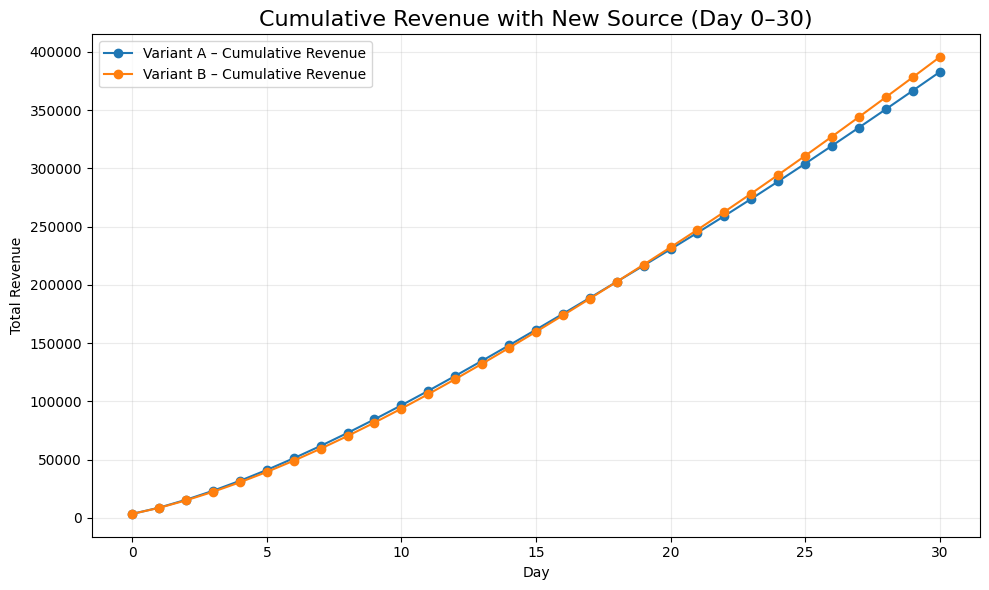

In [463]:
df_mix_30["cum_rev_A"] = df_mix_30["rev_A"].cumsum()
df_mix_30["cum_rev_B"] = df_mix_30["rev_B"].cumsum()

plt.figure(figsize=(10, 6))
plt.plot(df_mix_30["day"], df_mix_30["cum_rev_A"], marker="o", label="Variant A – Cumulative Revenue")
plt.plot(df_mix_30["day"], df_mix_30["cum_rev_B"], marker="o", label="Variant B – Cumulative Revenue")

plt.title("Cumulative Revenue with New Source (Day 0–30)", fontsize=16)
plt.xlabel("Day")
plt.ylabel("Total Revenue")
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.savefig("../outputs/figures/cumulative_rev_with_new_source.png", dpi=150, bbox_inches="tight")
plt.show()


**Result:** We model two streams: 12k installs/day from the original source (using our previous retention) and 8k installs/day from the new source (with exponential retention curves).

Although Variant A monetizes slightly better per user (more ad impressions), Variant B’s stronger long-tail retention for both old and new users results in a higher cumulative DAU and thus higher total revenue by Day 30.

### Which one should you prioritize, and why? If you could only make one of these improvements:
1. Run the temporary 10-day sale (from d)

2. Add the new, permanent user source (from e/f)


Day 30:  Sale = 429,088   |   New Source = 395,347
Day 45:  Sale = 670,574   |   New Source = 665,777
Day 60:  Sale = 914,923   |   New Source = 945,491


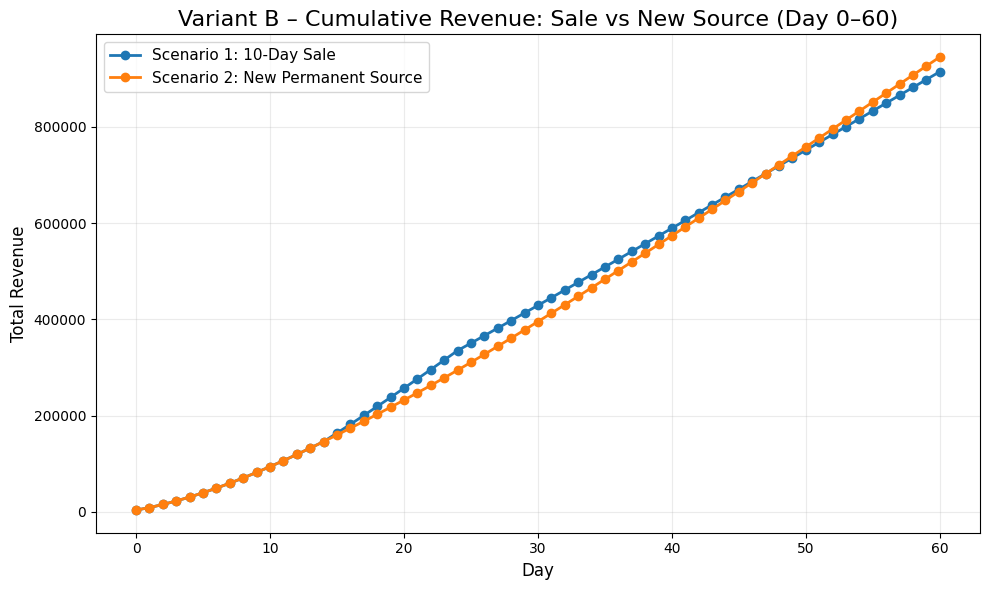

In [464]:


# --- Build comparison dataframe for Day 0–60 ---
rows = []
for t in range(max_day + 1):
    # Scenario 1: 10-day sale (DAU = baseline)
    dau_t_base = dau_baseline(t)
    rev_sale_t = daily_revenue_with_sale(t, dau_t_base, variant)
    
    # Scenario 2: New permanent source (no sale, but higher DAU from new cohorts)
    dau_t_new = dau_with_two_sources_variant(t)
    rev_newsource_t = daily_revenue(dau_t_new, variant)
    
    rows.append((t, dau_t_base, dau_t_new, rev_sale_t, rev_newsource_t))

df_scen = pd.DataFrame(
    rows,
    columns=["day", "dau_baseline", "dau_newsource", "rev_sale", "rev_newsource"]
)

# Cumulative revenue for each scenario
df_scen["cum_rev_sale"] = df_scen["rev_sale"].cumsum()
df_scen["cum_rev_newsource"] = df_scen["rev_newsource"].cumsum()

# --- Inspect key horizons: Day 30, 45, 60 ---
for d in [30, 45, 60]:
    row = df_scen.loc[df_scen["day"] == d].iloc[0]
    print(
        f"Day {d}:  "
        f"Sale = {row['cum_rev_sale']:,.0f}   |   "
        f"New Source = {row['cum_rev_newsource']:,.0f}"
    )

# --- 5) Plot cumulative revenue curves ---
plt.figure(figsize=(10, 6))

plt.plot(
    df_scen["day"],
    df_scen["cum_rev_sale"],
    marker="o",
    linewidth=2,
    label="Scenario 1: 10-Day Sale"
)
plt.plot(
    df_scen["day"],
    df_scen["cum_rev_newsource"],
    marker="o",
    linewidth=2,
    label="Scenario 2: New Permanent Source"
)

plt.title("Variant B – Cumulative Revenue: Sale vs New Source (Day 0–60)", fontsize=16)
plt.xlabel("Day", fontsize=12)
plt.ylabel("Total Revenue", fontsize=12)
plt.grid(alpha=0.25)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig("../outputs/figures/sale_vs_new_source.png", dpi=150, bbox_inches="tight")
plt.show()


**Priority: Add the new permanent user source.**

The 10-day sale is a short-term revenue spike. It increases ARPDAU during the event, but the
effect disappears immediately after the sale ends.

In contrast, the new user source increases the number of new players *every single day*. With
strong retention curves, these new cohorts stack and produce long-tail DAU growth. Higher DAU
benefits both IAP and ad revenue, creating compounding, permanent gains.

**A permanent increase in user inflow always outperforms a temporary monetization boost.**
